# Day 4: Cointegration & Pairs Trading

## 🎯 Learning Objectives
- Understand cointegration vs correlation
- Build pairs trading strategies
- Implement spread trading

---

## 📚 Theory: Cointegration

### Definition
Two non-stationary series are cointegrated if a linear combination is stationary.

$$Y_t - \beta X_t = \epsilon_t \quad (\epsilon_t \text{ is stationary})$$

### Key Insight
- Correlation: Series move together
- Cointegration: Series maintain long-run equilibrium

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download ETF pairs
tickers = ['XLF', 'KBE']  # Financial sector ETFs
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


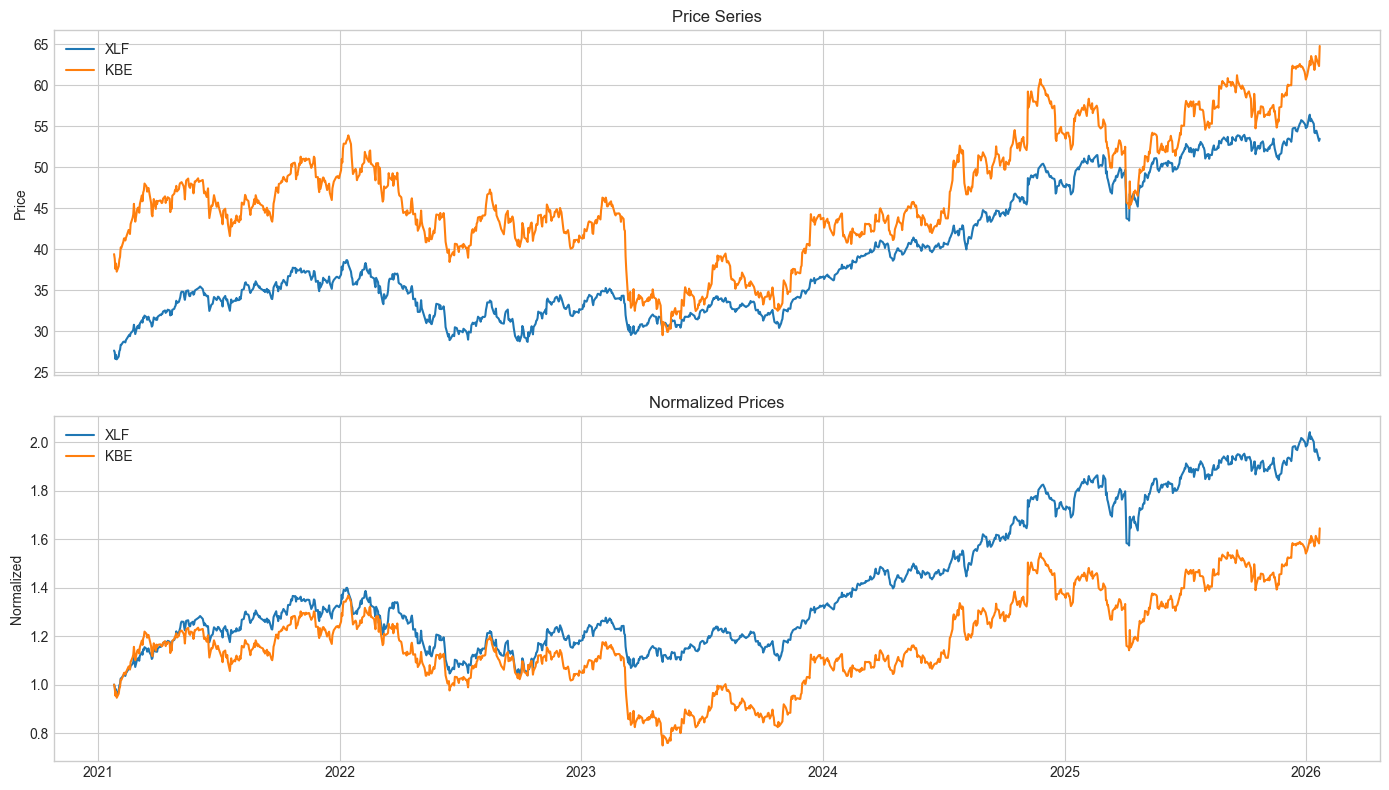


Correlation: 0.857


In [2]:
# Visualize prices
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(prices.index, prices[tickers[0]], label=tickers[0])
axes[0].plot(prices.index, prices[tickers[1]], label=tickers[1])
axes[0].set_title('Price Series')
axes[0].set_ylabel('Price')
axes[0].legend()

# Normalized
normalized = prices / prices.iloc[0]
axes[1].plot(normalized.index, normalized[tickers[0]], label=tickers[0])
axes[1].plot(normalized.index, normalized[tickers[1]], label=tickers[1])
axes[1].set_title('Normalized Prices')
axes[1].set_ylabel('Normalized')
axes[1].legend()

plt.tight_layout()
plt.show()

# Correlation
corr = prices.corr().iloc[0, 1]
print(f"\nCorrelation: {corr:.3f}")

In [3]:
# Cointegration test
def test_cointegration(y, x):
    score, pvalue, _ = coint(y, x)
    return score, pvalue

print("\n" + "="*60)
print("COINTEGRATION TEST")
print("="*60)

score, pvalue = test_cointegration(prices[tickers[0]], prices[tickers[1]])
print(f"\nCointegration Score: {score:.4f}")
print(f"p-value: {pvalue:.4f}")
print(f"\nCointegrated: {'Yes' if pvalue < 0.05 else 'No'}")


COINTEGRATION TEST

Cointegration Score: -1.7881
p-value: 0.6355

Cointegrated: No


In [4]:
# Calculate spread using OLS
train_size = int(len(prices) * 0.6)
train = prices.iloc[:train_size]

# Find hedge ratio
model = LinearRegression()
X = train[tickers[1]].values.reshape(-1, 1)
y = train[tickers[0]].values
model.fit(X, y)

hedge_ratio = model.coef_[0]
intercept = model.intercept_

print(f"\nHedge Ratio: {hedge_ratio:.4f}")
print(f"Intercept: {intercept:.4f}")


Hedge Ratio: 0.2841
Intercept: 21.2099



Spread ADF Statistic: -0.8049
p-value: 0.8177
Spread Stationary: No


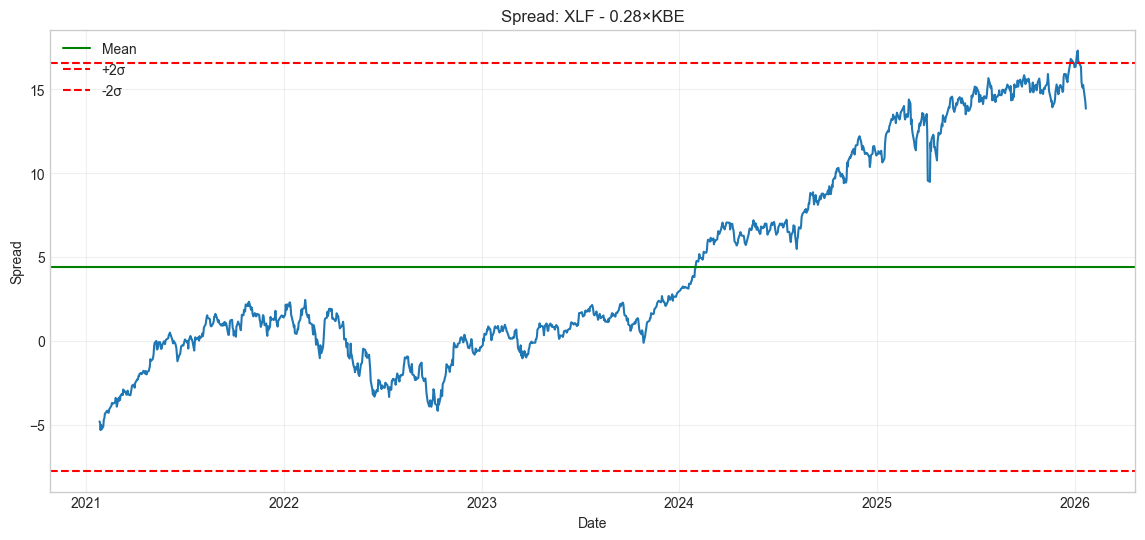

In [5]:
# Calculate spread
spread = prices[tickers[0]] - hedge_ratio * prices[tickers[1]] - intercept

# Test spread stationarity
adf_result = adfuller(spread.dropna())
print(f"\nSpread ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Spread Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")

# Plot spread
plt.figure(figsize=(14, 6))
plt.plot(spread.index, spread.values)
plt.axhline(y=spread.mean(), color='g', linestyle='-', label='Mean')
plt.axhline(y=spread.mean() + 2*spread.std(), color='r', linestyle='--', label='+2σ')
plt.axhline(y=spread.mean() - 2*spread.std(), color='r', linestyle='--', label='-2σ')
plt.title(f'Spread: {tickers[0]} - {hedge_ratio:.2f}×{tickers[1]}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Pairs trading strategy
df = pd.DataFrame(index=prices.index)
df['spread'] = spread
df['spread_zscore'] = (df['spread'] - df['spread'].rolling(20).mean()) / df['spread'].rolling(20).std()

# Entry threshold: 2 std, Exit: 0
entry_threshold = 2
exit_threshold = 0

# Generate signals
df['signal'] = 0
position = 0
for i in range(1, len(df)):
    zscore = df['spread_zscore'].iloc[i]
    if position == 0:
        if zscore < -entry_threshold:
            position = 1  # Long spread (long stock1, short stock2)
        elif zscore > entry_threshold:
            position = -1  # Short spread
    elif position == 1:
        if zscore > exit_threshold:
            position = 0
    elif position == -1:
        if zscore < exit_threshold:
            position = 0
    df.iloc[i, df.columns.get_loc('signal')] = position

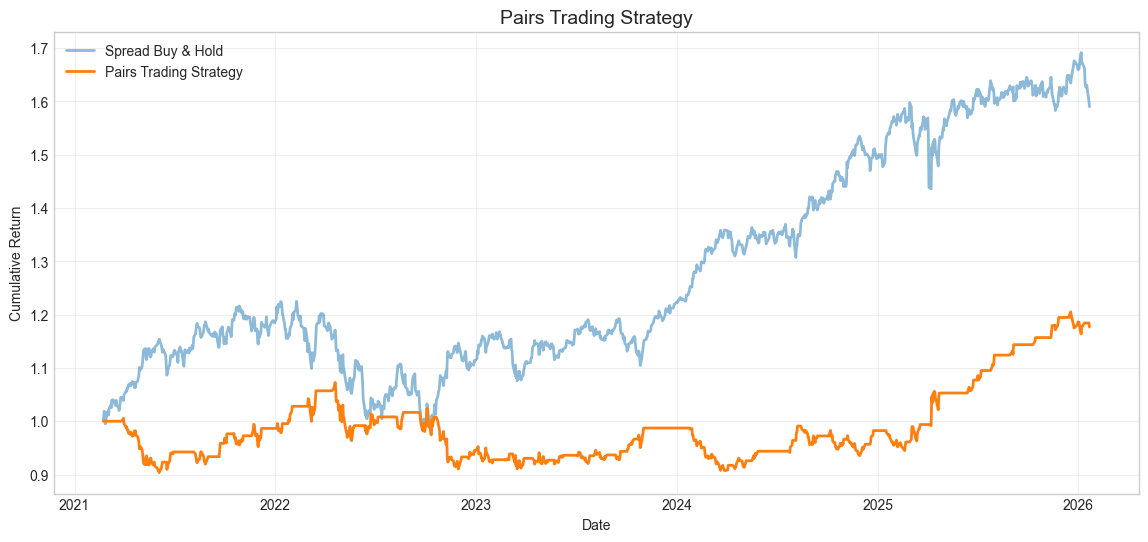

In [7]:
# Calculate returns
returns = prices.pct_change()
df['stock1_return'] = returns[tickers[0]]
df['stock2_return'] = returns[tickers[1]]

# Spread return = long stock1 - hedge_ratio * short stock2
df['spread_return'] = df['stock1_return'] - hedge_ratio * df['stock2_return']
df['strategy_return'] = df['signal'].shift(1) * df['spread_return']

df = df.dropna()
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['spread_cum'] = (1 + df['spread_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['spread_cum'], label='Spread Buy & Hold', linewidth=2, alpha=0.5)
plt.plot(df.index, df['strategy_cum'], label='Pairs Trading Strategy', linewidth=2)
plt.title('Pairs Trading Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\nPairs Trading Strategy:")
print(f"  Total Return: {st_total:.2%}")
print(f"  Sharpe Ratio: {st_sharpe:.2f}")
print(f"  Max Drawdown: {st_mdd:.2%}")

# Trade statistics
trades = df['signal'].diff().abs().sum() / 2
print(f"\n  Number of Round-Trip Trades: {int(trades)}")
win_rate = (df['strategy_return'] > 0).sum() / (df['strategy_return'] != 0).sum()
print(f"  Win Rate (trading days): {win_rate:.1%}")


STRATEGY PERFORMANCE

Pairs Trading Strategy:
  Total Return: 17.69%
  Sharpe Ratio: -0.14
  Max Drawdown: -15.41%

  Number of Round-Trip Trades: 47
  Win Rate (trading days): 50.0%


In [9]:
# Current signal
current_zscore = df['spread_zscore'].iloc[-1]
current_signal = df['signal'].iloc[-1]

print("\n" + "="*60)
print(f"📊 PAIRS TRADING SIGNAL")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrices:")
print(f"  {tickers[0]}: ${prices[tickers[0]].iloc[-1]:.2f}")
print(f"  {tickers[1]}: ${prices[tickers[1]].iloc[-1]:.2f}")
print(f"\nHedge Ratio: {hedge_ratio:.4f}")
print(f"Current Spread: {df['spread'].iloc[-1]:.4f}")
print(f"Spread Z-Score: {current_zscore:.2f}")

if current_signal == 1:
    print(f"\n🎯 Signal: LONG SPREAD")
    print(f"   Long {tickers[0]}, Short {hedge_ratio:.2f} units of {tickers[1]}")
elif current_signal == -1:
    print(f"\n🎯 Signal: SHORT SPREAD")
    print(f"   Short {tickers[0]}, Long {hedge_ratio:.2f} units of {tickers[1]}")
else:
    print(f"\n🎯 Signal: NO POSITION")
    if current_zscore < -entry_threshold:
        print(f"   (Approaching LONG entry at z < -{entry_threshold})")
    elif current_zscore > entry_threshold:
        print(f"   (Approaching SHORT entry at z > {entry_threshold})")


📊 PAIRS TRADING SIGNAL

Date: 2026-01-21

Prices:
  XLF: $53.46
  KBE: $64.78

Hedge Ratio: 0.2841
Current Spread: 13.8440
Spread Z-Score: -2.42

🎯 Signal: LONG SPREAD
   Long XLF, Short 0.28 units of KBE


---

## 🏢 Real-World Applications

| Company | Pairs Trading Use |
|---------|------------------|
| D.E. Shaw | Statistical arbitrage |
| Renaissance | Mean reversion |
| Two Sigma | Factor-neutral trading |

---
## 📅 Tomorrow: State Space Models